# Image Segmentation Using K-Means

## 1. Read and Display Image

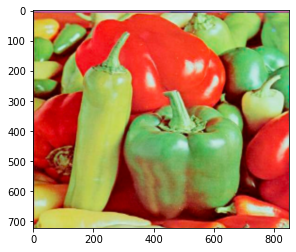

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
img = Image.open("Images/Peppers.png")
plt.figure()
plt.imshow(img)
plt.draw()

## 2. Convert Image to Numpy Array

In [2]:
import numpy as np
A = np.asarray(img, dtype=np.float32)
print("Shape of numpy array for image:", A.shape)
# Image properties
nbRows = A.shape[0]
nbCols = A.shape[1]
print("Image size: " + str(nbRows) + "x" + str(nbCols))
# The third dimension contains the R, G, and B values, and a transparency value that can be ignored for segmentation
# The array needs to be reshaped to contain all pixels in the first dimension and their features in the second dimension
points = A[:,:,:3].reshape(nbRows * nbCols, 3)
print("Shape of numpy array for segmentation:", points.shape)

Shape of numpy array for image: (722, 850, 4)
Image size: 722x850
Shape of numpy array for segmentation: (613700, 3)


## 3. Image Segmentation
### 3.1 Using KMeans Implementation

SSE: 1106859652.8024287
[[182.73076  196.93169   98.66791 ]
 [231.7184    53.93147   38.288044]
 [121.93244  162.20755   84.77618 ]
 [119.696396  20.256891  11.466355]
 [189.78018  215.74097  183.05359 ]]


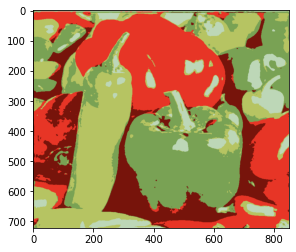

In [3]:
# Needed to reload ATCS_KMeans module in case it has changed
import sys
#del sys.modules['ATCS_KMeans']
from ATCS_KMeans import ATCS_KMeans
# Create kmeans object and cluster points
kmeans = ATCS_KMeans(points, 5, init = '++', nbInit = 5, tolerance = .1, maxIter = 100)
kmeans.cluster_points()
print("SSE:", kmeans.calculate_SSE())
print(kmeans.centroids)
# Generate and display segmented image
segmentation = kmeans.centroids[kmeans.classification]
imSeg = segmentation.reshape(nbRows, nbCols, 3).astype(np.uint8)
plt.figure()
plt.imshow(Image.fromarray(imSeg))
plt.draw()

### 3.2. Using scikit-learn Implementation

SSE: 1119404416.0
[[183.08795  193.39127   93.089966]
 [231.16158   56.187172  39.699646]
 [122.97252   20.853569  11.818874]
 [119.9645   168.33894   90.52621 ]
 [195.92703  213.67125  180.29578 ]]


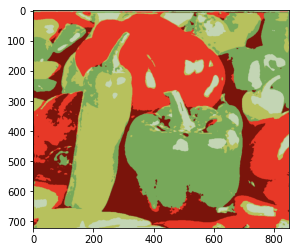

In [4]:
from sklearn.cluster import KMeans
# Create kmeans object and cluster points
kmeans = KMeans(n_clusters = 5, init = 'k-means++', n_init = 5, tol = 1, max_iter = 100)
labels = kmeans.fit_predict(points)
print("SSE:", kmeans.inertia_)
print(kmeans.cluster_centers_)
# Generate and display segmented image
segmentation = kmeans.cluster_centers_[labels]
imSeg = segmentation.reshape(nbRows, nbCols, 3).astype(np.uint8)
plt.figure()
plt.imshow(Image.fromarray(imSeg))
plt.draw()

### 3.3. Segmentation in HSV Space

In [5]:
import colorsys

# Convert array from RGB to HSV
def RGBtoHSV(RGBdata):
    rgb = RGBdata / 255
    HSVdata = np.zeros(RGBdata.shape)
    for i in range(0, rgb.shape[0]):
        h, s, v = colorsys.rgb_to_hsv(rgb[i][0], rgb[i][1], rgb[i][2])
        HSVdata[i] = [h, s, v]
    return HSVdata

# Convert array from HSV to RGB
def HSVtoRGB(HSVdata):
    RGBdata = np.zeros(HSVdata.shape)
    for i in range(0, HSVdata.shape[0]):
        r, g, b = colorsys.hsv_to_rgb(HSVdata[i][0], HSVdata[i][1], HSVdata[i][2])
        r = min(255, max(0, r * 255))
        g = min(255, max(0, g * 255))
        b = min(255, max(0, b * 255))
        RGBdata[i] = [r, g, b]
    return RGBdata

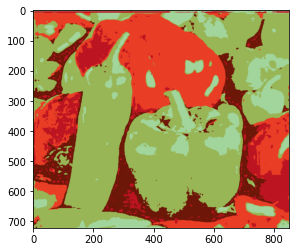

In [6]:
from sklearn.cluster import KMeans
# Convert data points from RGB to HSV space
HSVpoints = RGBtoHSV(points)
# Create kmeans object and cluster points
kmeans = KMeans(n_clusters = 5, random_state = 0)
labels = kmeans.fit_predict(HSVpoints)
# Convert cluster centers from HSV back to RGB space
RGBcenters = HSVtoRGB(kmeans.cluster_centers_)
# Generate and display segmented image
segmentation = RGBcenters[labels]
imSeg = segmentation.reshape(nbRows, nbCols, 3).astype(np.uint8)
plt.figure()
plt.imshow(Image.fromarray(imSeg))
plt.draw()

## 4. Determine the Number of Regions

In [7]:
from sklearn.cluster import KMeans
nbRegions = range(2, 10)
SSEs = []
centers = []
labels = []
for k in nbRegions:
    print(k)
    kmeans = KMeans(n_clusters = k, random_state = 0)
    labs = kmeans.fit_predict(points)
    SSEs.append(kmeans.inertia_)
    centers.append(kmeans.cluster_centers_)
    labels.append(labs)
print("Done")

2
3
4
5
6
7
8
9
Done


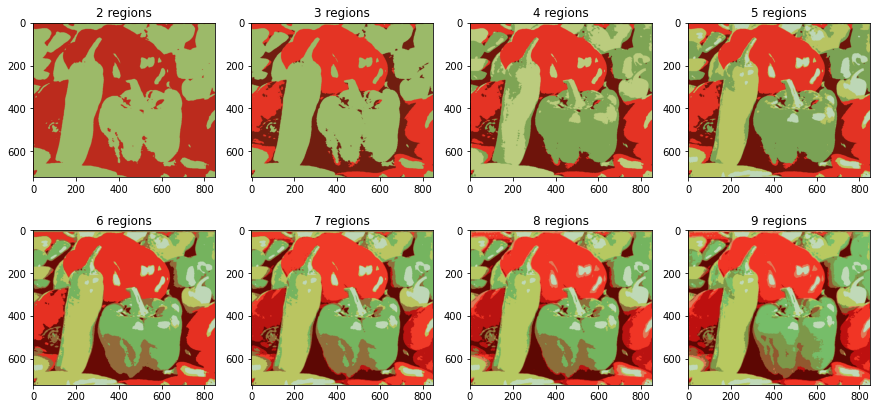

In [8]:
# Show the segmentation results for each k
fig, ax = plt.subplots(2, 4, figsize = (15,7))
for k in nbRegions:
    idx = k-nbRegions[0]
    segmentation = centers[idx][labels[idx]]
    imSeg = segmentation.reshape(nbRows, nbCols, 3).astype(np.uint8)
    i = (k-nbRegions[0])//4
    j = (k-nbRegions[0])%4
    ax[i,j].imshow(Image.fromarray(imSeg))
    ax[i,j].set_title(str(k) + " regions")

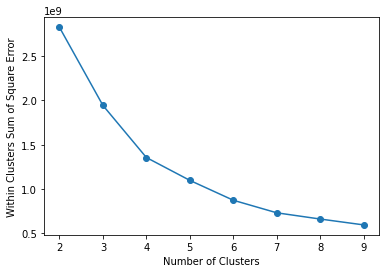

In [9]:
# Plot the SSE vs the number of cluster centers
plt.figure()
plt.plot(nbRegions, SSEs, marker = "o")
plt.xlabel("Number of Clusters")
plt.ylabel("Within Clusters Sum of Square Error")
plt.show()